In [1]:
#include<TFile.h>
#include<TH1.h>
#include<TMath.h>
#include<math.h>
#include<TF1.h>
#include<TLine.h>
#include<TPoint.h>
#include<iostream>
#include<string>
#include<stdio.h>

In [2]:
void PrintCanvas(TCanvas* c1, string title) {
    string outFolder="Optimization";
    string tpng = outFolder+"/"+title+".png";
    c1->SaveAs(tpng.c_str());

    string tpdf = outFolder+"/"+title+".pdf";
    c1->SaveAs(tpdf.c_str());

    string troot = outFolder+"/"+title+".root";
    c1->SaveAs(troot.c_str());
    
    return;
}

In [3]:
TCanvas *c1 = new TCanvas("c1","c1",900, 600); //este es comodin, por si queremos dibujar algo
c1->SetGrid();
gStyle->SetPalette(1); //opcional: cambia la paleta de colores en los plots. 

In [4]:
Float_t fSig = 0.7; // Fracción de señal.
Int_t nEntries = 20; // Número de entradas.
Float_t minVal = 110.000; //Valor mínimo del intervalo.
Float_t maxVal = 135.000; //Valor máximo del intervalo.

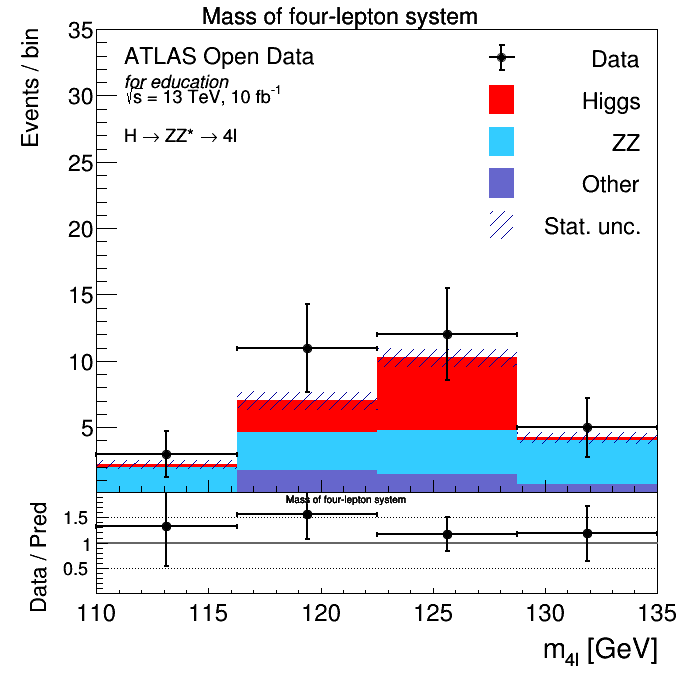

In [5]:
TFile *f = new TFile("//Plotting/histograms/mass_four_lep.root","READ");
//f->ls();
TH1F * h1 = (TH1F*)f->Get("c");
h1->Draw();

In [6]:
/*ofstream fout("//Optimization/output.txt");
for(int i=1;i<=h->GetNbinsX();i++) { 
    for(int j=1;j<=h->GetNbinsY();j++) {
        fout<<h1->GetXaxis()->GetBinCenter(i)<<" "<<h1->GetYaxis()->GetBinCenter(j)<<" "<<h1->GetBinContent(i,j)<<endl;
    }
}
fout.close();*/

In [7]:
/*// obtain the statistical uncertainty
float err;
int nbin = h1->GetNbinsX();
for(int i_bin=0;i_bin<=nbin;i_bin++){
    err = histstack->GetBinError(i_bin);
    histstack->SetBinError(i_bin, err ); 
}*/

In [8]:
Int_t n = 7;
Int_t nbins = 7;
TH1D *h_data = new TH1D("h_data","h_data",n,minVal,maxVal); // Histograma de datos.

// Para 7:
if (n == 7) {  
    h_data->SetBinContent(1, 1);
    h_data->SetBinContent(2, 0);
    h_data->SetBinContent(3, 1);
    h_data->SetBinContent(4, 6);
    h_data->SetBinContent(5, 4);
    h_data->SetBinContent(6, 0);
    h_data->SetBinContent(7, 2);
}

In [9]:
//PDF de la señal, más info: https://root.cern.ch/root/html524/TMath.html#TMath:Gaus
//signalModel = new TF1("signalModel","[2]*TMath::Landau(x,[0],[1],1)",minVal,maxVal);
//signalModel = new TF1("signalModel","[2]*TMath::Gaus(x,[0],[1],1)",minVal,maxVal);
signalModel = new TF1("signalModel","[2]*TMath::BreitWigner(x,[0],[1])",minVal,maxVal);
signalModel->SetParNames("mass","sigma"); //nombres de los parámetros
signalModel->SetParameters(123.8,5.35,1); //valores de los parámetros
//signalModel->FixParameter(0,123.8);

Y ahora, los combinamos y hacemos el ajuste de los parámetros.

In [10]:
c1->cd();

data =  new TH1D("data","data",nbins, minVal,maxVal);
data->GetXaxis()->SetTitle("x [GeV]");
// data->GetYaxis()->SetTitle("Entries / {} GeV".format((maxVal-minVal)/nbins)); /////////////Preguntar
data->Add(h_data);
data->Draw("e");

r = data->Fit("signalModel",  "LQS", "", minVal, maxVal); // L: likelihood, Q: quiet, reduce printing, S: save fit result 

//cout << "Minval: " << r->MinFcnValue() << endl ;
r->Print("v");
//c1->Draw();




****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      3.64248
Chi2                      =      3.81851
NDf                       =            4
Edm                       =   4.9706e-07
NCalls                    =          159
mass                      =      123.835   +/-   0.841637    
sigma                     =      5.34602   +/-   2.91281     
p2                        =      58.6465   +/-   15.9213     

Covariance Matrix:

            	        mass       sigma          p2
mass        	     0.70835    -0.39948     0.81726
sigma       	    -0.39948      8.4845      7.0733
p2          	     0.81726      7.0733      253.49

Correlation Matrix:

            	        mass       sigma          p2
mass        	           1    -0.16295     0.06099
sigma       	    -0.16295           1     0.15252
p2          	     0.06099     0.15252           1


Info in <TCanvas::Print>: png file Optimization/fit.png has been created
Info in <TCanvas::Print>: pdf file Optimization/fit.pdf has been created


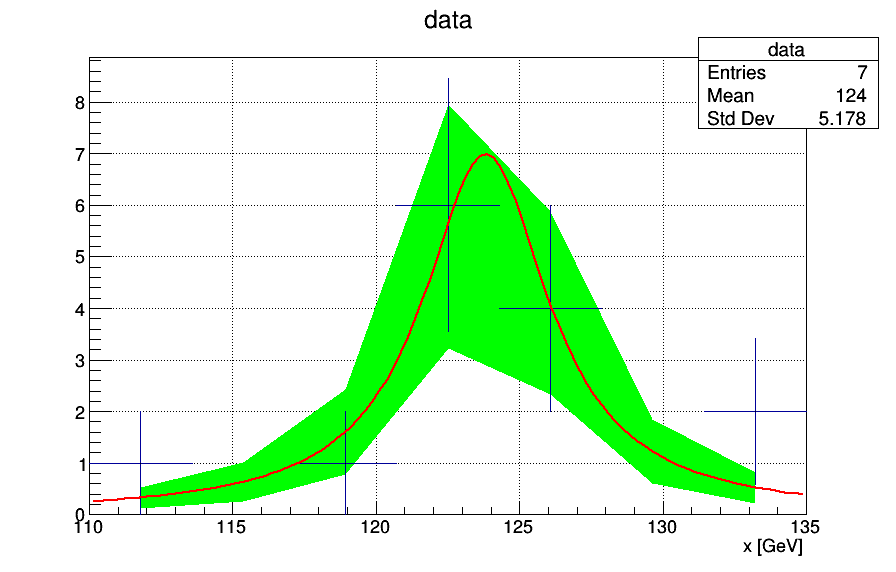

Info in <TCanvas::SaveAs>: ROOT file Optimization/fit.root has been created


In [11]:
TGraphErrors *gr = new TGraphErrors(data);
Int_t nPoints = data->GetNbinsX();
  for (Int_t i=0; i<nPoints; i++){
    gr->SetPoint(i, data->GetBinCenter(i+data->FindBin(110)), 0); 
}
(TVirtualFitter::GetFitter())->GetConfidenceIntervals(gr,0.68);
gr->SetFillColor(3);

gr->Draw("E3") ; 
data->Draw("same e"); 
c1->Draw("same");
PrintCanvas(c1, "fit");

Primero creamos un histograma bidimensional

In [12]:
Float_t stepMass = 0.5;
Float_t stepWidth = 0.25;
binMass = int((maxVal-minVal)/stepMass);
binWidth = int(10./stepWidth);
chi2dPlot = new TH2D("chi2dPlot","chi2dPlot",binMass,minVal-stepMass/2.0,maxVal-stepMass/2.0,binWidth,0.5,10.5);

cout << "binMass: " << binMass << endl;
cout << "binWidth: " << binWidth << endl;

binMass: 50
binWidth: 40


Luego realizamos ajustes fijando tanto la masa como la anchura, de forma que nos permitan obtener el $\chi^{2}$ en función de dichos parámetros. Sin fijarlos, obtendríamos siempre el valor que más se ajuste a los datos (en el mínimo!).  

In [13]:
//this is for the chi2 on the mass and width
chi2dPlot->Clear();
for (Float_t masses = minVal; masses < maxVal; masses+=stepMass){
    //cout << "Filling: externo mass: "<< masses << ". bin:" << chi2dPlot->GetXaxis()->FindBin(masses) << endl;
    for (double widths = 0.25; widths < 10.5; widths+=stepWidth){
        //cout << "Filling: interno mass and bin: " << widths << chi2dPlot->GetYaxis()->FindBin(widths) << endl;
        
        for (Int_t i=0; i<2; i++) signalModel->ReleaseParameter(i);
        signalModel->FixParameter(0,masses);
        signalModel->FixParameter(1,widths);
        r = data->Fit("signalModel","QLS");
        chi2dPlot->SetBinContent(chi2dPlot->FindBin(masses,widths),r->MinFcnValue());
    }
}

Info in <TCanvas::Print>: png file Optimization/2D_hyperspace.png has been created


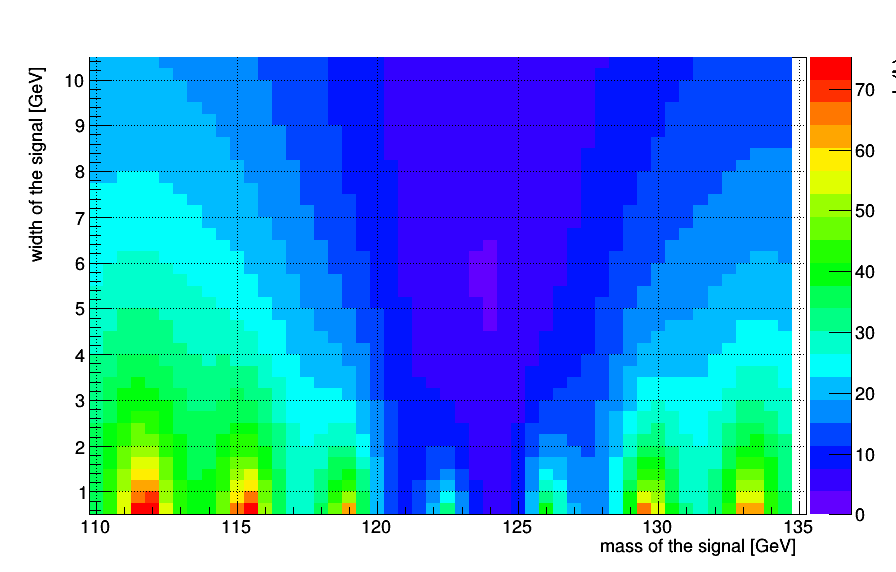

Info in <TCanvas::Print>: pdf file Optimization/2D_hyperspace.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file Optimization/2D_hyperspace.root has been created


In [14]:
//remove borders..
//chi2dPlot->SetAxisRange(0.5,10,"y");
//chi2dPlot->SetAxisRange(0,20,"z");
chi2dPlot->SetAxisRange(110,135,"x");
chi2dPlot->GetXaxis()->SetTitle("mass of the signal [GeV]");
chi2dPlot->GetYaxis()->SetTitle("width of the signal [GeV]");
chi2dPlot->GetZaxis()->SetTitle("ln(L)");
chi2dPlot->Draw("colz");
gStyle->SetOptStat(000000);
c1->Draw();
PrintCanvas(c1, "2D_hyperspace");

Info in <TCanvas::Print>: png file Optimization/3D_hyperspace.png has been created


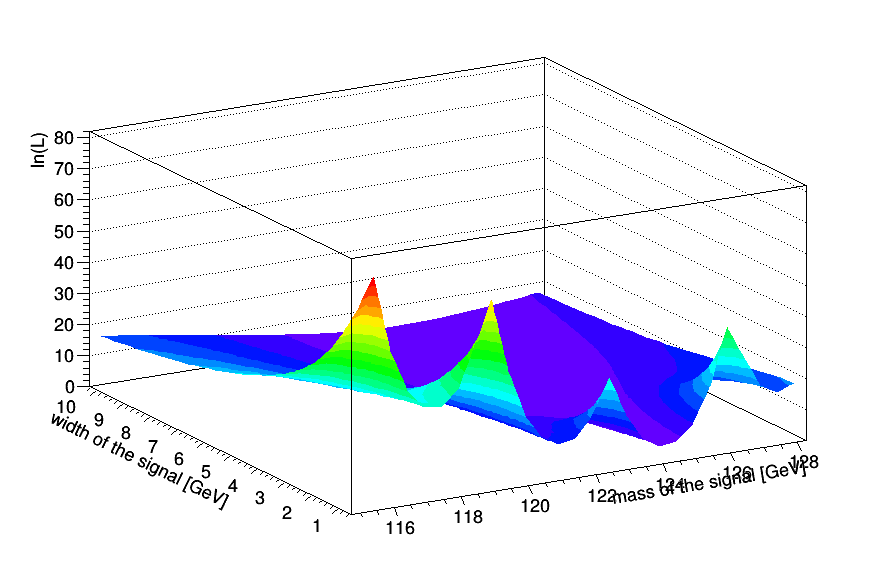

Info in <TCanvas::Print>: pdf file Optimization/3D_hyperspace.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file Optimization/3D_hyperspace.root has been created


In [15]:
// remove borders..
chi2dPlot->SetAxisRange(0.5,10,"y");
chi2dPlot->SetAxisRange(115,128,"x");
chi2dPlot->GetXaxis()->SetTitle("mass of the signal [GeV]");
chi2dPlot->GetYaxis()->SetTitle("width of the signal [GeV]");
chi2dPlot->GetZaxis()->SetTitle("ln(L)");
chi2dPlot->Draw("surf2");
gStyle->SetOptStat(000000);
c1->Draw();
PrintCanvas(c1, "3D_hyperspace");